<a href="https://colab.research.google.com/github/pratamastan/bangkit-capstone0143/blob/main/NLP_project_2_HPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Fetching and train-test split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 97 kB 2.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt
# import pathlib
# from os import getcwd

Training data is taken from Quora Questions Pairs dataset (training set only) https://www.kaggle.com/c/quora-question-pairs/overview translated to Indonesian with Google Translate

In [ ]:
data1=pd.read_csv("/content/drive/MyDrive/Quora question pair dataset/train complete indo.csv")

In [ ]:
data1=data1.dropna()

In [ ]:
data1.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,Apa panduan langkah demi langkah untuk berinve...,Apa panduan langkah demi langkah untuk berinve...,0
1,1,3,4,Bagaimana kisah Berlian Kohinoor (Koh-i-Noor)?,Apa yang akan terjadi jika pemerintah India me...,0
2,2,5,6,Bagaimana cara meningkatkan kecepatan koneksi ...,Bagaimana kecepatan Internet dapat ditingkatka...,0
3,3,7,8,Mengapa saya secara mental sangat kesepian? Ba...,Temukan sisanya ketika [math] 23 ^ {24} [/ mat...,0
4,4,9,10,Manakah yang larut dalam air seperti gula pasi...,Ikan apa yang akan bertahan hidup di air asin?,0


In [ ]:
data1.question1.str.len().max()

717

In [ ]:
data1.question2.str.len().max()

1395

Train-test split 80% 20%

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1[["question1", "question2"]], data1["is_duplicate"], test_size=0.2, random_state=42)

Transform the dataframe to NumPy array as TensorFlow takes NumPy arrays

In [ ]:
xt=X_train.to_numpy()
yt=y_train.to_numpy()

xte=X_test.to_numpy()
yte=y_test.to_numpy()

Q1_train = X_train["question1"].to_numpy()
Q2_train = X_train["question2"].to_numpy()
Q1_test = X_test["question1"].to_numpy()
Q2_test = X_test["question2"].to_numpy()

In [ ]:
Q1_train

array(['Apa sajakah cerita pendeknya?',
       'Apa jawaban terbaik untuk pertanyaan HR, "Anda berasal dari latar belakang ECE, jadi mengapa Anda ingin bergabung dengan perusahaan IT"?',
       'Bagaimana cara membulatkan 1,44 ke persen terdekat?', ...,
       'Siapa yang saat ini memenangkan pemilihan presiden?',
       'Apa sajakah film Telugu / Tamil / Hindi yang pemeran utamanya menjadi mafia atau tidak?',
       'Berapa peringkat yang dipotong untuk perguruan tinggi Kedokteran Rohtak dalam kuota negara bagian?'],
      dtype=object)

In [ ]:
data1["question1"][0]

'Apa panduan langkah demi langkah untuk berinvestasi di pasar saham di India?'

In [ ]:
data1[["question1","question2"]]

,question1,question2
0,Apa panduan langkah demi langkah untuk berinve...,Apa panduan langkah demi langkah untuk berinve...
1,Bagaimana kisah Berlian Kohinoor (Koh-i-Noor)?,Apa yang akan terjadi jika pemerintah India me...
2,Bagaimana cara meningkatkan kecepatan koneksi ...,Bagaimana kecepatan Internet dapat ditingkatka...
3,Mengapa saya secara mental sangat kesepian? Ba...,Temukan sisanya ketika [math] 23 ^ {24} [/ mat...
4,Manakah yang larut dalam air seperti gula pasi...,Ikan apa yang akan bertahan hidup di air asin?
...,...,...
404285,Ada berapa kata kunci dalam bahasa pemrograman...,Ada berapa kata kunci dalam Bahasa Pemrograman...
404286,Apakah Anda percaya ada kehidupan setelah kema...,Benarkah ada kehidupan setelah kematian?
404287,Apa satu koin?,Koin apa ini?
404288,Berapa perkiraan biaya hidup tahunan selama be...,Saya mengalami sedikit masalah rambut rontok t...


In [ ]:
#Model runtime will increase if tranable=True to about 900-1000s per epoch
embed = hub.KerasLayer("https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2",input_shape=[], dtype=tf.string)
#embed.trainable=True

In [ ]:
xt1=embed(Q1_train)
xt2=embed(Q2_train)
xte1=embed(Q1_test)
xte2=embed(Q2_test)

In [ ]:
xt1

<tf.Tensor: shape=(323430, 128), dtype=float32, numpy=
array([[ 0.03792422, -0.08203722, -0.03952134, ..., -0.03751129,
        -0.13026127, -0.21294448],
       [ 0.16049062,  0.05221158, -0.03756306, ..., -0.06843793,
        -0.16083518,  0.00526717],
       [ 0.00541904,  0.03682816, -0.10739181, ..., -0.05703003,
        -0.12414219, -0.05216019],
       ...,
       [ 0.17406467,  0.06946962, -0.02178098, ..., -0.05727712,
        -0.17851247, -0.00691927],
       [ 0.14288372, -0.16400667,  0.03347619, ...,  0.04388543,
        -0.12863201, -0.02391369],
       [-0.02106932, -0.22670205, -0.11702876, ..., -0.13742013,
        -0.11424292,  0.08969257]], dtype=float32)>

# Final Models
## Models with two inputs and embedding integrated

## Model with GRU layer

In [ ]:
# Model with Bidirectional LSTM, GRU, without Attention, will run for about 150-200s per epoch
def model_builder(hp):
  hp_units1 = hp.Int('units_1', min_value=64, max_value=512, step=32)
  hp_units2 = hp.Int('units_2', min_value=64, max_value=512, step=32)
  hp_units3 = hp.Int('units_3', min_value=64, max_value=512, step=32)
  hp_units4 = hp.Int('units_4', min_value=64, max_value=512, step=32)
  hp_rate1 = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.2,step=0.05)
  hp_rate2 = hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.2,step=0.05)
  hp_rate3 = hp.Float('dropout_3',min_value=0.0,max_value=0.5,default=0.2,step=0.05)
  hp_rate4 = hp.Float('dropout_4',min_value=0.0,max_value=0.5,default=0.2,step=0.05)

  qstn1=tf.keras.Input(shape=(), dtype=tf.string)
  qstn2=tf.keras.Input(shape=(), dtype=tf.string)

  qu1=embed(qstn1)
  qu2=embed(qstn2)
  concat=tf.keras.layers.concatenate([qu1,qu2])
  concat=tf.keras.layers.Reshape((2,128))(concat)
  concat=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(concat)
  concat=tf.keras.layers.GRU(64, return_sequences=True)(concat)
  concat=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(concat)
  concat=tf.keras.layers.Dense(units=hp_units1,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate1)(concat)
  concat=tf.keras.layers.BatchNormalization()(concat)
  concat=tf.keras.layers.Dense(units=hp_units2,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate2)(concat)
  concat=tf.keras.layers.BatchNormalization()(concat)
  concat=tf.keras.layers.Dense(units=hp_units3,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate3)(concat)
  concat=tf.keras.layers.BatchNormalization()(concat)
  concat=tf.keras.layers.Dense(units=hp_units4,activation='relu')(concat)
  concat=tf.keras.layers.Dropout(rate=hp_rate4)(concat)
  concat=tf.keras.layers.BatchNormalization()(concat)
  is_dupe=tf.keras.layers.Dense(1, activation="sigmoid")(concat)

  model4 = tf.keras.models.Model(inputs=[qstn1,qstn2], outputs=is_dupe)
  model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model4

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_trials=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
tuner.search([Q1_train, Q2_train], yt, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the densely-connected
layer are {best_hps.get('units_1')}, {best_hps.get('units_2')}, {best_hps.get('units_3')}, {best_hps.get('units_4')} and the optimal droupout rate for the optimizer
is {best_hps.get('dropout_1')}, {best_hps.get('dropout_1')}, {best_hps.get('dropout_1')}, {best_hps.get('dropout_1')}.
""")


Trial 10 Complete [00h 07m 33s]
val_accuracy: 0.7507033944129944

Best val_accuracy So Far: 0.7533624172210693
Total elapsed time: 01h 17m 51s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
units_1           |480               |224               
units_2           |224               |352               
units_3           |288               |160               
units_4           |448               |384               
dropout_1         |0.25              |0.5               
dropout_2         |0.35              |0.2               
dropout_3         |0.5               |0                 
dropout_4         |0.4               |0.45              
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/2


KeyboardInterrupt: ignored

In [24]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[26][0]           

In [31]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the densely-connected
layer are {best_hps.get('units_1')}, {best_hps.get('units_2')}, {best_hps.get('units_3')}, {best_hps.get('units_4')} and the optimal droupout rate for the optimizer
is {best_hps.get('dropout_1')}, {best_hps.get('dropout_1')}, {best_hps.get('dropout_1')}, {best_hps.get('dropout_1')}.
""")



The hyperparameter search is complete. The optimal number of units in the densely-connected
layer are 224, 352, 160, 384 and the optimal droupout rate for the optimizer
is 0.5, 0.5, 0.5, 0.5.



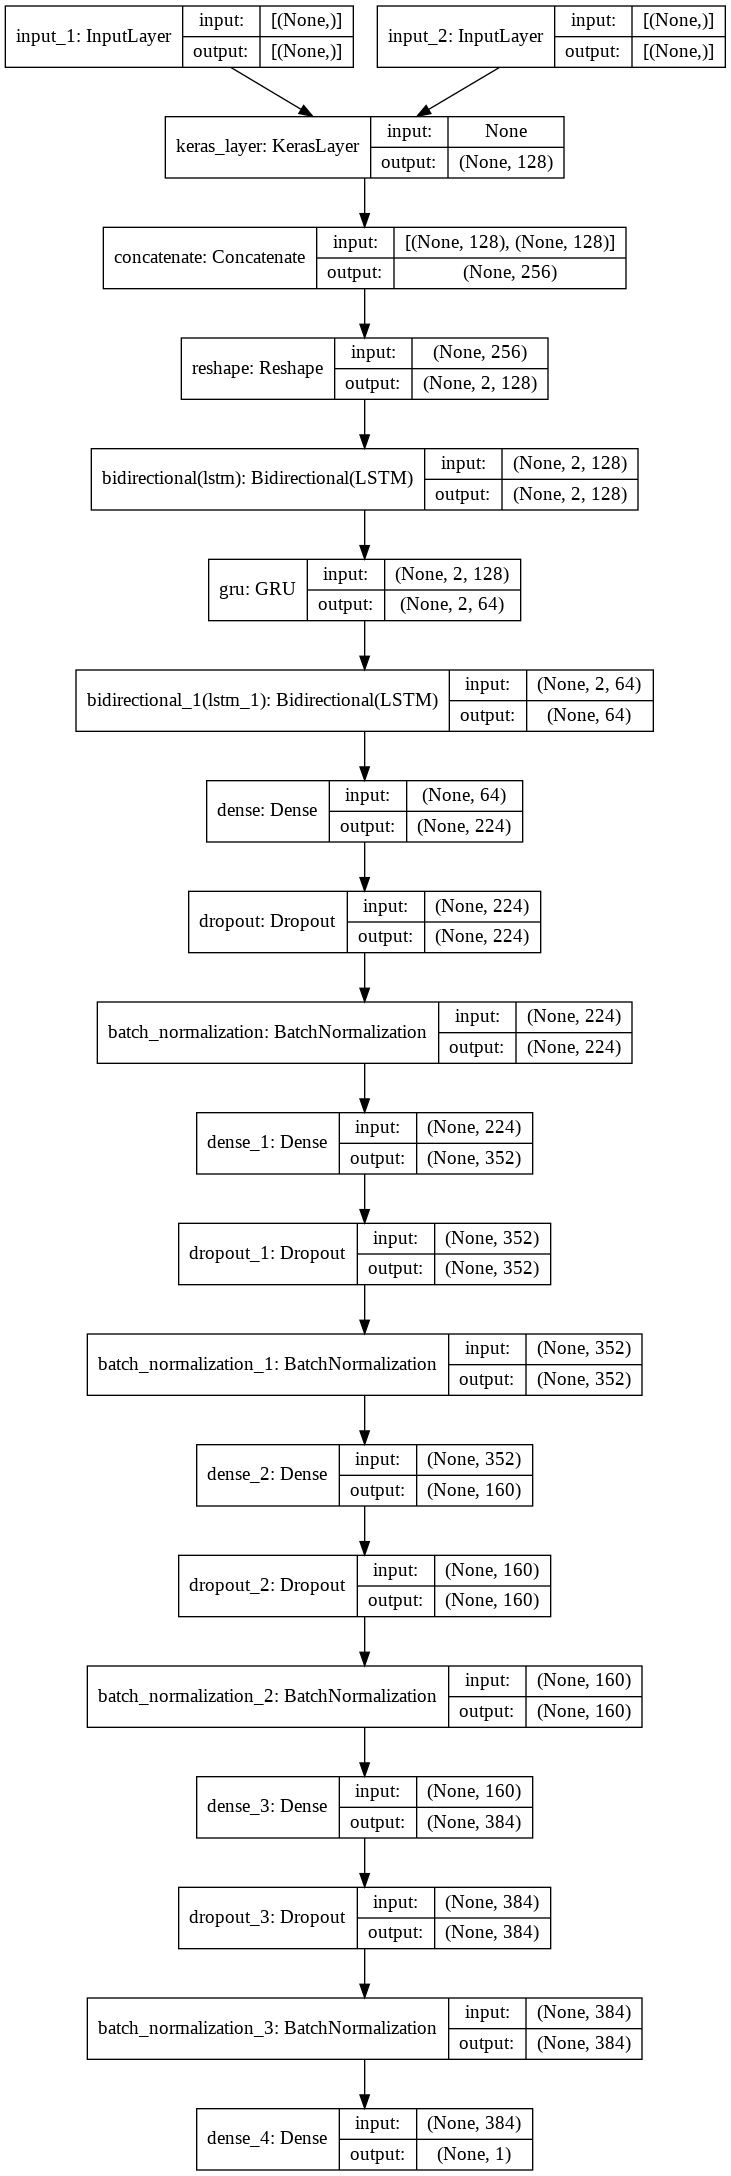

In [25]:
tf.keras.utils.plot_model(best_model, show_shapes=True)

In [33]:
history = best_model.fit([Q1_train, Q2_train],yt, epochs=10, validation_split=0.2)

Epoch 1/10
8086/8086 [==============================] - 244s 28ms/step - loss: 0.4806 - accuracy: 0.7601 - val_loss: 0.4638 - val_accuracy: 0.7668
Epoch 2/10
8086/8086 [==============================] - 222s 27ms/step - loss: 0.4609 - accuracy: 0.7728 - val_loss: 0.4541 - val_accuracy: 0.7744
Epoch 3/10
8086/8086 [==============================] - 224s 28ms/step - loss: 0.4452 - accuracy: 0.7828 - val_loss: 0.4492 - val_accuracy: 0.7796
Epoch 4/10
8086/8086 [==============================] - 219s 27ms/step - loss: 0.4329 - accuracy: 0.7908 - val_loss: 0.4411 - val_accuracy: 0.7833
Epoch 5/10
8086/8086 [==============================] - 221s 27ms/step - loss: 0.4200 - accuracy: 0.7986 - val_loss: 0.4393 - val_accuracy: 0.7830
Epoch 6/10
8086/8086 [==============================] - 224s 28ms/step - loss: 0.4095 - accuracy: 0.8051 - val_loss: 0.4361 - val_accuracy: 0.7875
Epoch 7/10
8086/8086 [==============================] - 218s 27ms/step - loss: 0.4000 - accuracy: 0.8107 - val_loss: 0

In [ ]:
# history4 = model4.fit([Q1_train, Q2_train],
#                     yt,
#                     epochs=10,
#                     validation_data=([Q1_test,Q2_test], yte),
#                     verbose=2)

Epoch 1/10
10108/10108 - 253s - loss: 0.5762 - accuracy: 0.6988 - val_loss: 0.5281 - val_accuracy: 0.7285
Epoch 2/10
10108/10108 - 218s - loss: 0.5016 - accuracy: 0.7464 - val_loss: 0.4768 - val_accuracy: 0.7610
Epoch 3/10
10108/10108 - 210s - loss: 0.4701 - accuracy: 0.7662 - val_loss: 0.4647 - val_accuracy: 0.7710
Epoch 4/10
10108/10108 - 211s - loss: 0.4495 - accuracy: 0.7799 - val_loss: 0.4487 - val_accuracy: 0.7809
Epoch 5/10
10108/10108 - 211s - loss: 0.4339 - accuracy: 0.7906 - val_loss: 0.4371 - val_accuracy: 0.7867
Epoch 6/10
10108/10108 - 212s - loss: 0.4195 - accuracy: 0.7997 - val_loss: 0.4341 - val_accuracy: 0.7876
Epoch 7/10
10108/10108 - 212s - loss: 0.4073 - accuracy: 0.8071 - val_loss: 0.4389 - val_accuracy: 0.7868
Epoch 8/10
10108/10108 - 211s - loss: 0.3961 - accuracy: 0.8139 - val_loss: 0.4296 - val_accuracy: 0.7960
Epoch 9/10
10108/10108 - 215s - loss: 0.3858 - accuracy: 0.8207 - val_loss: 0.4220 - val_accuracy: 0.7987
Epoch 10/10
10108/10108 - 213s - loss: 0.3761 

In [43]:
eval_result = best_model.evaluate([Q1_test,Q2_test], yte)
print("[test loss, test accuracy]:", eval_result)


2527/2527 [==============================] - 27s 11ms/step - loss: 0.4387 - accuracy: 0.7926
[test loss, test accuracy]: [0.4386768341064453, 0.7926488518714905]


In [34]:
prediction4 = best_model.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])
print(prediction4)

[[0.7762513]]


In [35]:
best_model.predict([np.asarray(["saya yang mempunyai gitar yamaha itu"]),np.asarray(["gitar yamaha itu milik saya"])])

array([[0.6900268]], dtype=float32)

In [36]:
best_model.predict([np.asarray(["saya bermain di atas meja"]),np.asarray(["kursi diduduki oleh saya"])])

array([[0.00754181]], dtype=float32)

In [48]:
best_model.predict([np.asarray(["dia gemar berbohong"]),np.asarray(["dia suka berdusta"])])

array([[0.90214956]], dtype=float32)

In [57]:
best_model.predict([np.asarray(["saya suka mencuri"]),np.asarray(["saya demen maling"])])

array([[0.8532923]], dtype=float32)

In [60]:
best_model.predict([np.asarray(["saya mencuri berlian itu"]),np.asarray(["dia mencuri berlian mahal"])])

array([[0.09305909]], dtype=float32)

### Save the first model

In [52]:
export_dir1 = 'saved_model/model_gru1_HPT'
best_model.save(export_dir1)


INFO:tensorflow:Assets written to: saved_model/model_gru1_HPT/assets


INFO:tensorflow:Assets written to: saved_model/model_gru1_HPT/assets


### Try to load model from saved model

In [53]:
new_model4 = tf.keras.models.load_model(export_dir1)
# nnew_model4 = tf.keras.models.load_model("/content/drive/MyDrive/saved_model/model_gru1")
new_model4.summary()
# nnew_model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 128)          112461824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           keras_layer[0][0]            

In [54]:
new_model4.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])
# nnew_model4.predict([np.asarray(["saya memukul kursi"]),np.asarray(["kursi dipukul oleh saya"])])

array([[0.7762513]], dtype=float32)

In [55]:
new_model4.predict([np.asarray(["dia gemar berbohong"]),np.asarray(["dia suka berdusta"])])

array([[0.90214956]], dtype=float32)

# Save model to Drive

In [56]:
#save model to MyDrive
!cp -r /content/saved_model /content/drive/MyDrive/